In [1]:
# Only run in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Only run in google colab
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [3]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category = UndefinedMetricWarning)

In [331]:
# To get statistics
allZeroCnt = 0
allNegativeCnt = 0
allPositiveCnt = 0
allTotalCnt = 0
wantedYearsLen = 6    # We want to get the yearly statistics for 6 years from 1394 to 1399
allZeroCntPerYear = [0] * wantedYearsLen
allNegativeCntPerYear = [0] * wantedYearsLen
allPositiveCntPerYear = [0] * wantedYearsLen

In [5]:
def getData(dataFileName):
    data = pd.read_excel(dataFileName, index_col = None)
    return data

def renameColumns(data):
    data.columns = ['TICKER', 'MDATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'VALUE', 'NUMOFTRADES', 
                    'YESTERDAYPRICE', 'CODE', 'LATINNAME', 'NAME', 'SHDATE', 'LASTPRICE']

In [609]:
fileName = "./Assets/Adjusted/وسينا-ت.xls"
# وسينا-ت.xls
# فولاد-ت.xls
# وبملت-ت.xls
# وبصادر-ت.xls
# وتجارت-ت.xls
# فملي-ت.xls
# خودرو-ت.xls
# خساپا-ت.xls
# خپارس-ت.xls
# ومعادن-ت.xls
# شپنا-ت.xls

data = getData(fileName)
renameColumns(data)
data.head()

TICKER     MDATE   OPEN  ...         NAME    SHDATE  LASTPRICE
0  وسينا-ت  20070925  39.24  ...  بانك سينا-ت  13860703      39.27
1  وسينا-ت  20070926  40.05  ...  بانك سينا-ت  13860704      39.99
2  وسينا-ت  20070929  39.24  ...  بانك سينا-ت  13860707      39.27
3  وسينا-ت  20070930  38.50  ...  بانك سينا-ت  13860708      38.50
4  وسينا-ت  20071001  37.75  ...  بانك سينا-ت  13860709      37.75

[5 rows x 15 columns]

In [333]:
fileName = "./Assets/Adjusted/شاخص كل6.xls"
overallIndexData = getData(fileName)
renameColumns(overallIndexData)
overallIndexData.head()

TICKER     MDATE    OPEN  ...     NAME    SHDATE  LASTPRICE
0  شاخص كل6  20081206  9248.8  ...  شاخص كل  13870916     9178.3
1  شاخص كل6  20081207  9178.3  ...  شاخص كل  13870917     9130.5
2  شاخص كل6  20081208  9102.7  ...  شاخص كل  13870918     9089.2
3  شاخص كل6  20081210  9071.6  ...  شاخص كل  13870920     9023.7
4  شاخص كل6  20081213  8973.3  ...  شاخص كل  13870923     8973.3

[5 rows x 15 columns]

In [334]:
def calcPivotPoints(high, low, close):
    pivotPoints = (high + low + close) / 3
    return pivotPoints

def calcSupports(high, low, pivotPoint):
    support1 = (pivotPoint * 2) - high
    support2 = pivotPoint - (high - low)
    return support1, support2

def calcResistances(high, low, pivotPoint):
    resistance1 = (pivotPoint * 2) - low
    resistance2 = pivotPoint + (high - low)
    return resistance1, resistance2

def calcOverallIndexDifferenceWithSuports(lastPrice, support1, support2):
    sup1Difference = lastPrice - support1
    sup2Difference = lastPrice - support2
    return sup1Difference, sup2Difference

def calcOverallIndexDifferenceWithResistances(lastPrice, resistance1, resistance2):
    res1Difference = lastPrice - resistance1
    res2Difference = lastPrice - resistance2
    return res1Difference, res2Difference

In [335]:
high = overallIndexData["HIGH"]
low = overallIndexData["LOW"]
close = overallIndexData["CLOSE"]
lastPrice = overallIndexData["LASTPRICE"]
pivotPoint = calcPivotPoints(high, low, close)
overallIndexData["PIVOT"] = pivotPoint
support1, support2 = calcSupports(high, low, pivotPoint)
resistance1, resistance2 = calcResistances(high, low, pivotPoint)
overallIndexData["SUPPORT1"] = support1
overallIndexData["SUPPORT2"] = support2
overallIndexData["RESISTANCE1"] = resistance1
overallIndexData["RESISTANCE2"] = resistance2
sup1Difference, sup2Difference = calcOverallIndexDifferenceWithSuports(lastPrice, support1, support2)
res1Difference, res2Difference = calcOverallIndexDifferenceWithResistances(lastPrice, resistance1, resistance2)
overallIndexData["SUP1DIFFERENCE"] = sup1Difference
overallIndexData["SUP2DIFFERENCE"] = sup2Difference
overallIndexData["RES1DIFFERENCE"] = res1Difference
overallIndexData["RES2DIFFERENCE"] = res2Difference

In [336]:
overallIndexData.head()

TICKER     MDATE    OPEN  ...  SUP2DIFFERENCE  RES1DIFFERENCE  RES2DIFFERENCE
0  شاخص كل6  20081206  9248.8  ...       61.000000      -50.500000     -101.000000
1  شاخص كل6  20081207  9178.3  ...       32.133333      -31.933333      -63.866667
2  شاخص كل6  20081208  9102.7  ...       22.266667      -12.666667      -25.333333
3  شاخص كل6  20081210  9071.6  ...       31.933333      -31.933333      -63.866667
4  شاخص كل6  20081213  8973.3  ...        0.200000        0.100000        0.200000

[5 rows x 24 columns]

In [610]:
dataIndices = []
overallIndexDataIndices = []
for day, value in zip(overallIndexData["SHDATE"].values, overallIndexData["LASTPRICE"].values):
    k = data.index[data["SHDATE"] == day].tolist()
    g = overallIndexData.index[overallIndexData["SHDATE"] == day].tolist()
    if len(k) == 1:
        dataIndices.extend(k)
        overallIndexDataIndices.extend(g)
data["OVERALLINDEX"] = np.nan
data["SUP1DIFFERENCE"] = np.nan
data["SUP2DIFFERENCE"] = np.nan
data["RES1DIFFERENCE"] = np.nan
data["RES2DIFFERENCE"] = np.nan
for i in range(len(dataIndices)):
    data["OVERALLINDEX"][dataIndices[i]] = overallIndexData["LASTPRICE"][overallIndexDataIndices[i]]
    data["SUP1DIFFERENCE"][dataIndices[i]] = overallIndexData["SUP1DIFFERENCE"][overallIndexDataIndices[i]]
    data["SUP2DIFFERENCE"][dataIndices[i]] = overallIndexData["SUP2DIFFERENCE"][overallIndexDataIndices[i]]
    data["RES1DIFFERENCE"][dataIndices[i]] = overallIndexData["RES1DIFFERENCE"][overallIndexDataIndices[i]]
    data["RES2DIFFERENCE"][dataIndices[i]] = overallIndexData["RES2DIFFERENCE"][overallIndexDataIndices[i]]
data.head()

TICKER     MDATE   OPEN  ...  SUP2DIFFERENCE  RES1DIFFERENCE  RES2DIFFERENCE
0  وسينا-ت  20070925  39.24  ...             NaN             NaN             NaN
1  وسينا-ت  20070926  40.05  ...             NaN             NaN             NaN
2  وسينا-ت  20070929  39.24  ...             NaN             NaN             NaN
3  وسينا-ت  20070930  38.50  ...             NaN             NaN             NaN
4  وسينا-ت  20071001  37.75  ...             NaN             NaN             NaN

[5 rows x 20 columns]

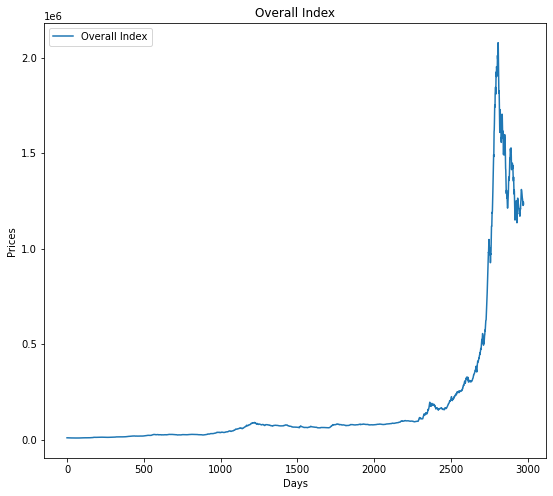

In [338]:
overallIndexSeries = overallIndexData['CLOSE']
overallIndexSeries.index = np.arange(overallIndexSeries.shape[0])

plt.figure(1, figsize=(9, 8))
plt.title("Overall Index")
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(overallIndexSeries, label="Overall Index")
plt.legend()
plt.show()

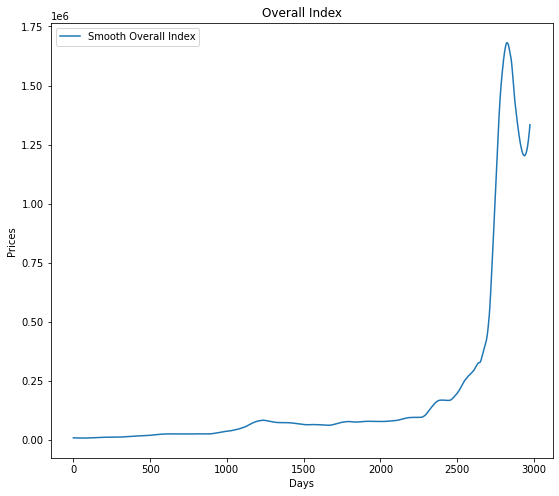

In [339]:
month_diff = overallIndexSeries.shape[0] // 30 # Integer divide the number of prices we have by 30
if month_diff == 0: # We want a value greater than 0
    month_diff = 1
smooth = int(2 * month_diff + 3) # Simple algo to determine smoothness
overallIndexPts = savgol_filter(overallIndexSeries, smooth, 3) # Get the smoothened price data

plt.figure(1, figsize=(9, 8))
plt.title("Overall Index")
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(overallIndexPts, label="Smooth Overall Index")
plt.legend()
plt.show()

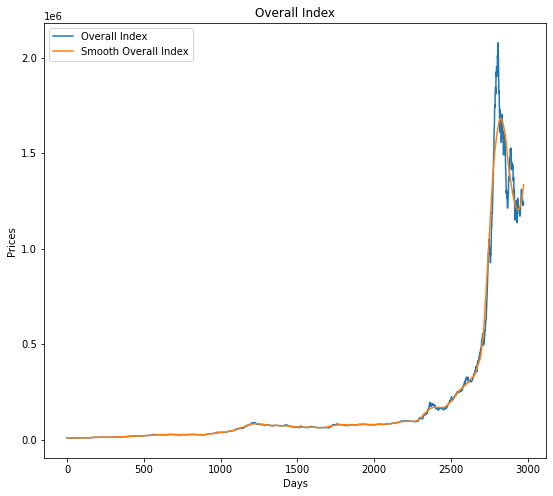

In [340]:
plt.figure(1, figsize=(9, 8))
plt.title("Overall Index")
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(overallIndexSeries, label="Overall Index")
plt.plot(overallIndexPts, label="Smooth Overall Index")
plt.legend()
plt.show()

In [341]:
def pythag(pt1, pt2):   # Pythagorean theorem to determine the distance
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    return sqrt(a_sq + b_sq)

def localMinMax(pts):
    local_min = []
    local_max = []
    prev_pts = [(0, pts[0]), (1, pts[1])]
    for i in range(1, len(pts) - 1):
        append_to = ''
        if pts[i-1] > pts[i] < pts[i+1]:
            append_to = 'min'
        elif pts[i-1] < pts[i] > pts[i+1]:
            append_to = 'max'
        if append_to:
            if local_min or local_max:
                prev_distance = pythag(prev_pts[0], prev_pts[1]) * 0.5
                curr_distance = pythag(prev_pts[1], (i, pts[i]))
                if curr_distance >= prev_distance:
                    prev_pts[0] = prev_pts[1]
                    prev_pts[1] = (i, pts[i])
                    if append_to == 'min':
                        local_min.append((i, pts[i]))
                    else:
                        local_max.append((i, pts[i]))
            else:
                prev_pts[0] = prev_pts[1]
                prev_pts[1] = (i, pts[i])
                if append_to == 'min':
                    local_min.append((i, pts[i]))
                else:
                    local_max.append((i, pts[i]))
    return local_min, local_max

In [342]:
localMinList, localMaxList = localMinMax(overallIndexPts)

In [343]:
def regressionCeof(pts):
    X = np.array([pt[0] for pt in pts]).reshape(-1, 1)
    y = np.array([pt[1] for pt in pts])
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0], model.intercept_

localMinSlope, localMinInt = regressionCeof(localMinList)
localMaxSlope, localMaxInt = regressionCeof(localMaxList)

In [344]:
support = (localMinSlope * np.array(overallIndexSeries.index)) + localMinInt
resistance = (localMaxSlope * np.array(overallIndexSeries.index)) + localMaxInt

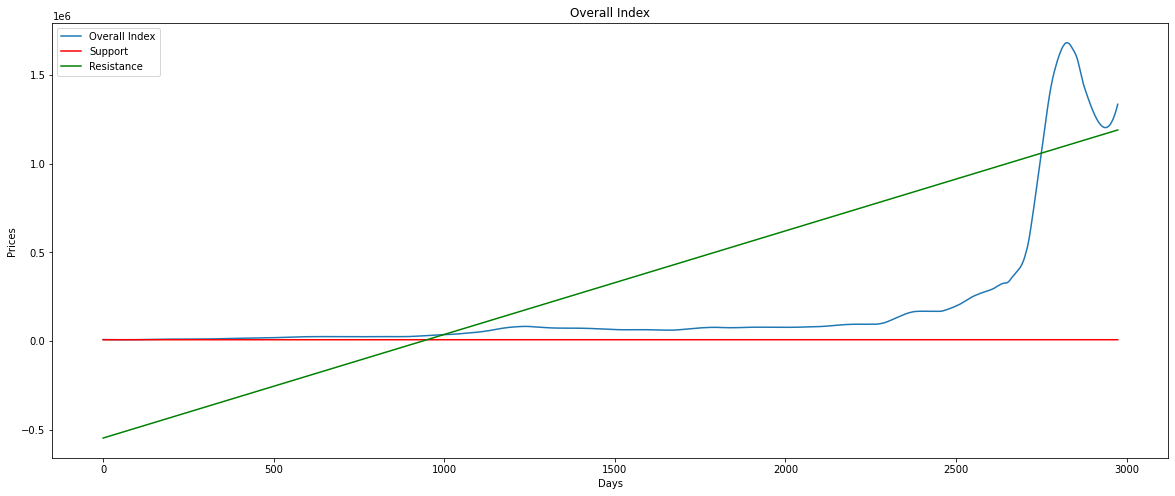

In [345]:
plt.figure(1, figsize=(20, 8))
plt.title("Overall Index")
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(overallIndexPts, label="Overall Index")
plt.plot(support, label='Support', c='r')
plt.plot(resistance, label='Resistance', c='g')
plt.legend()
plt.show()

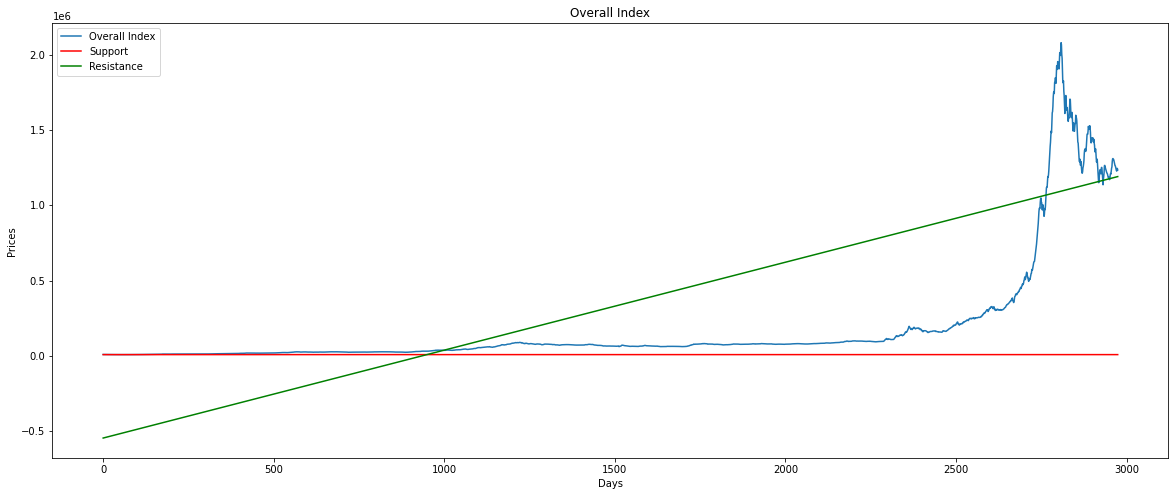

In [346]:
plt.figure(1, figsize=(20, 8))
plt.title("Overall Index")
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(overallIndexSeries, label="Overall Index")
plt.plot(support, label='Support', c='r')
plt.plot(resistance, label='Resistance', c='g')
plt.legend()
plt.show()

In [347]:
def calcOverallIndexDiffWithRes(overallIndex, localMaxSlope, localMaxInt):
    diffWithRes = []
    for i in overallIndex.index:
        res = localMaxSlope * i + localMaxInt
        diffWithRes.append(overallIndex[i] - res)
    return diffWithRes

diffWithRes = calcOverallIndexDiffWithRes(overallIndexSeries, localMaxSlope, localMaxInt)
# print(diffWithRes)

In [348]:
def calcOverallIndexDiffWithSup(overallIndex, localMinSlope, localMinInt):
    diffWithSup = []
    for i in overallIndex.index:
        sup = localMinSlope * i + localMinInt
        diffWithSup.append(overallIndex[i] - sup)
    return diffWithSup

diffWithSup = calcOverallIndexDiffWithSup(overallIndexSeries, localMinSlope, localMinInt)
# print(diffWithSup)

In [611]:
data["DIFFWITHRES"] = np.nan
data["DIFFWITHSUP"] = np.nan
for i in range(len(dataIndices)):
    data["DIFFWITHRES"][dataIndices[i]] = diffWithRes[overallIndexDataIndices[i]]
    data["DIFFWITHSUP"][dataIndices[i]] = diffWithSup[overallIndexDataIndices[i]]

In [306]:
def calcCCI(high, low, close, period):
    cci = ta.CCI(high, low, close, timeperiod = period)
    return cci

def calcRSI(close, period):
    rsi = ta.RSI(close, timeperiod = period)
    return rsi

def calcSTOCH(high, low, close, fastkPeriod, slowkPeriod, slowkMaType, slowdPeriod, slowdMaType):
    slowk, slowd = ta.STOCH(high, low, close, fastk_period=fastkPeriod, slowk_period=slowkPeriod,
                         slowk_matype=slowkMaType, slowd_period=slowdPeriod, slowd_matype=slowdMaType)
    return slowk, slowd

def calcMACD(close, fastPeriod, slowPeriod, signalPeriod):
    macd, macdsignal, macdhist = ta.MACD(close, fastPeriod, slowPeriod, signalPeriod)
    return macd, macdsignal, macdhist

def calcWilliamR(high, low, close, period):
    williamR = ta.WILLR(high, low, close, timeperiod = period)
    return williamR

def calcOBV(close, volume):
    obv = ta.OBV(close, volume)
    return obv

def calcAD(high, low, close, volume):
    ad = ta.AD(high, low, close, volume)
    return ad

def calcADOSC(high, low, close, volume, fastPeriod, slowPeriod):
    adosc = ta.ADOSC(high, low, close, volume, fastPeriod, slowPeriod)
    return adosc

In [233]:
def addIndicators(data):
    high = data["HIGH"]
    low = data["LOW"]
    close = data["CLOSE"]
    volume = data["VOL"]
    cci = calcCCI(high, low, close, 14)
    data["CCI"] = cci
    rsi = calcRSI(close, 14)
    data["RSI"] = rsi
    slowk, slowd = calcSTOCH(high, low, close, 5, 3, 0, 3, 0)
    data["SLOWK"] = slowk
    data["SLOWD"] = slowd
    macd, macdsignal, macdhist = calcMACD(close, 12, 26, 9)
    data["MACD"] = macd
    data["MACDSIGNAL"] = macdsignal
    data["MACDHIST"] = macdhist
    williamR = calcWilliamR(high, low, close, 14)
    data["WILLR"] = williamR
    obv = calcOBV(close, volume)
    data["OBV"] = obv
    ad = calcAD(high, low, close, volume)
    data["AD"] = ad
    adosc = calcADOSC(high, low, close, volume, 3, 10)
    data["ADOSC"] = adosc

In [187]:
def addPriceValueDiffs(data):
    openDiffPercent = data.OPEN.pct_change() * 100
    data["OPENDIFFPERCENT"] = openDiffPercent
    closeDiffPercent = data.CLOSE.pct_change() * 100
    data["CLOSEDIFFPERCENT"] = closeDiffPercent
    highDiffPercent = data.HIGH.pct_change() * 100
    data["HIGHDIFFPERCENT"] = highDiffPercent
    lowDiffPercent = data.LOW.pct_change() * 100
    data["LOWDIFFPERCENT"] = lowDiffPercent

In [188]:
def detectPriceDirection(close, yesterdayPrice, indifferenceRate):
    priceDifference = close - yesterdayPrice
    indifferenceValue = (indifferenceRate / 100) * close
    conditions = [(-indifferenceValue < priceDifference) & (priceDifference < indifferenceValue),
                  priceDifference > 0,
                  priceDifference < 0]
    choices = [0, 1, -1]
    priceDirection = pd.DataFrame()
    priceDirection["PRICEDIRECTION"] = np.select(conditions, choices)
    priceDirection["PRICEDIRECTION"] = priceDirection["PRICEDIRECTION"].shift(-1)
    return priceDirection["PRICEDIRECTION"]

In [612]:
addIndicators(data)
addPriceValueDiffs(data)
data["PRICEDIRECTION"] = detectPriceDirection(data["CLOSE"], data["YESTERDAYPRICE"], 0.5)
data.tail()

TICKER     MDATE  ...  LOWDIFFPERCENT  PRICEDIRECTION
2826  وسينا-ت  20210407  ...       -1.223242            -1.0
2827  وسينا-ت  20210410  ...       -1.857585            -1.0
2828  وسينا-ت  20210411  ...       -1.261830            -1.0
2829  وسينا-ت  20210412  ...       -1.916933             0.0
2830  وسينا-ت  20210413  ...       -1.628664             NaN

[5 rows x 38 columns]

In [613]:
data = data.dropna()
data.head()

TICKER     MDATE   OPEN  ...  HIGHDIFFPERCENT  LOWDIFFPERCENT  PRICEDIRECTION
273  وسينا-ت  20081206  32.86  ...              0.0             0.0            -1.0
274  وسينا-ت  20081207  33.15  ...              0.0             0.0             0.0
275  وسينا-ت  20081208  32.93  ...              0.0             0.0             0.0
276  وسينا-ت  20081210  33.09  ...              0.0             0.0             1.0
277  وسينا-ت  20081213  33.22  ...              0.0             0.0             1.0

[5 rows x 38 columns]

In [309]:
def getStatisticsPerYear(data):
    wantedYears = [1394, 1395, 1396, 1397, 1398, 1399]
    years = np.floor(data["SHDATE"] / 10000) 
    for i in range(wantedYearsLen):
        yearData = data.loc[(years == wantedYears[i]), 'PRICEDIRECTION']
        # print(wantedYears[i])
        # print(yearData)
        for d in yearData:
            if d == 0:
                allZeroCntPerYear[i] += 1
            if d == 1:
                allPositiveCntPerYear[i] += 1
            if d == -1:
                allNegativeCntPerYear[i] += 1
        # print(allZeroCntPerYear[i])
        # print(allPositiveCntPerYear[i])
        # print(allNegativeCntPerYear[i])
  
  
    x = np.arange(wantedYearsLen)
    width = 0.1  # the width of the bars
    plt.figure(figsize = (10, 7))
    plt.bar(x - width, allNegativeCntPerYear, width, label= '-1')
    plt.bar(x, allZeroCntPerYear, width, label= '0')
    plt.bar(x + width, allPositiveCntPerYear, width, label= '1')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.title('Directions\' Count per Year')
    plt.xticks(x, wantedYears)
    plt.legend()
    plt.show()
    print()

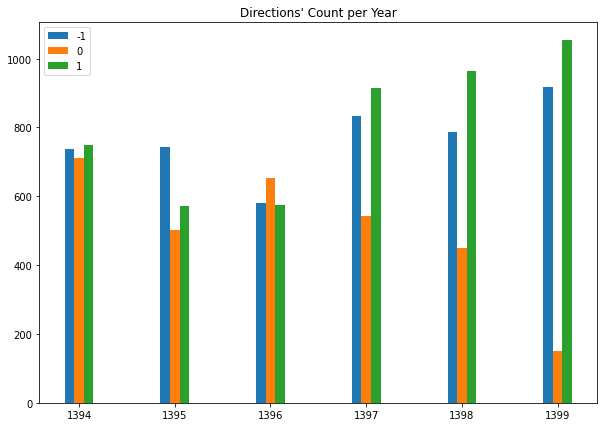

In [588]:
getStatisticsPerYear(data)

In [193]:
def separateFeaturesFromLabels(data, featureList):
    features = data[featureList]
    labels = data["PRICEDIRECTION"]
    print(features)
    print(labels)
    return features, labels

In [614]:
featureList = ["OPEN", "HIGH", "LOW", "CLOSE", "VOL", "NUMOFTRADES", "YESTERDAYPRICE", "SHDATE",
               "CCI", "RSI", "SLOWK", "SLOWD", "MACD", "MACDSIGNAL", "MACDHIST",
               "WILLR", "OBV", "AD", "ADOSC", "OVERALLINDEX", "SUP1DIFFERENCE", "SUP2DIFFERENCE",
               "RES1DIFFERENCE", "RES2DIFFERENCE", "DIFFWITHRES", "DIFFWITHSUP", 
               "OPENDIFFPERCENT", "CLOSEDIFFPERCENT", "HIGHDIFFPERCENT", "LOWDIFFPERCENT"]

In [615]:
features, labels = separateFeaturesFromLabels(data, featureList)

         OPEN  HIGH   LOW  ...  CLOSEDIFFPERCENT  HIGHDIFFPERCENT  LOWDIFFPERCENT
273     32.86    33    33  ...          0.000000         0.000000        0.000000
274     33.15    33    33  ...          0.000000         0.000000        0.000000
275     32.93    33    33  ...          0.578739         0.000000        0.000000
276     33.09    33    33  ...          0.121139         0.000000        0.000000
277     33.22    33    33  ...          0.483969         0.000000        0.000000
...       ...   ...   ...  ...               ...              ...             ...
2825  3320.00  3370  3270  ...         -1.201201        -0.295858       -1.801802
2826  3250.00  3280  3230  ...         -1.823708        -2.670623       -1.223242
2827  3190.00  3230  3170  ...         -1.238390        -1.524390       -1.857585
2828  3130.00  3190  3130  ...         -1.880878        -1.238390       -1.261830
2829  3070.00  3100  3070  ...         -1.597444        -2.821317       -1.916933

[2553 rows x 30

In [146]:
def getStatistics(labels):
    cntz = 0
    cntp = 0
    cntn = 0
    for l in labels:
        if l == 0:
            cntz += 1
        if l == 1:
            cntp += 1
        if l == -1:
            cntn += 1
    return cntz, cntp, cntn

In [ ]:
cntz, cntp, cntn = getStatistics(labels)
print("Z: ", cntz)
print("P: ", cntp)
print("N: ", cntn)
cntTotal = cntz + cntp + cntn
print(cntTotal)

allZeroCnt += cntz
allPositiveCnt += cntp
allNegativeCnt += cntn
print("allZeroCnt: ", allZeroCnt)
print("allPositiveCnt: ", allPositiveCnt)
print("allNegativeCnt: ", allNegativeCnt)
allTotalCnt += cntTotal
print("allTotalCnt: ", allTotalCnt)

In [616]:
featureList.remove("SHDATE")
print(featureList)

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'NUMOFTRADES', 'YESTERDAYPRICE', 'CCI', 'RSI', 'SLOWK', 'SLOWD', 'MACD', 'MACDSIGNAL', 'MACDHIST', 'WILLR', 'OBV', 'AD', 'ADOSC', 'OVERALLINDEX', 'SUP1DIFFERENCE', 'SUP2DIFFERENCE', 'RES1DIFFERENCE', 'RES2DIFFERENCE', 'DIFFWITHRES', 'DIFFWITHSUP', 'OPENDIFFPERCENT', 'CLOSEDIFFPERCENT', 'HIGHDIFFPERCENT', 'LOWDIFFPERCENT']


In [ ]:
def preprocess(features, featureList):
    stdScaler = StandardScaler()
    features[featureList] = stdScaler.fit_transform(features[featureList])
    return features

In [ ]:
# Don't run!
features = preprocess(features, featureList)

In [617]:
features

OPEN  HIGH   LOW  ...  CLOSEDIFFPERCENT  HIGHDIFFPERCENT  LOWDIFFPERCENT
273     32.86    33    33  ...          0.000000         0.000000        0.000000
274     33.15    33    33  ...          0.000000         0.000000        0.000000
275     32.93    33    33  ...          0.578739         0.000000        0.000000
276     33.09    33    33  ...          0.121139         0.000000        0.000000
277     33.22    33    33  ...          0.483969         0.000000        0.000000
...       ...   ...   ...  ...               ...              ...             ...
2825  3320.00  3370  3270  ...         -1.201201        -0.295858       -1.801802
2826  3250.00  3280  3230  ...         -1.823708        -2.670623       -1.223242
2827  3190.00  3230  3170  ...         -1.238390        -1.524390       -1.857585
2828  3130.00  3190  3130  ...         -1.880878        -1.238390       -1.261830
2829  3070.00  3100  3070  ...         -1.597444        -2.821317       -1.916933

[2553 rows x 30 columns]

In [37]:
def featureSelectionWithMutualInfo(features, labels):
    numOfFeatures = len(features.columns)
    discFeatures = [False] * numOfFeatures
    disc = [4, 5, 7]
    for i in disc:
        discFeatures[i] = True
    mutualInfos = mutual_info_classif(features, labels, discrete_features = discFeatures, copy = True)
    return mutualInfos

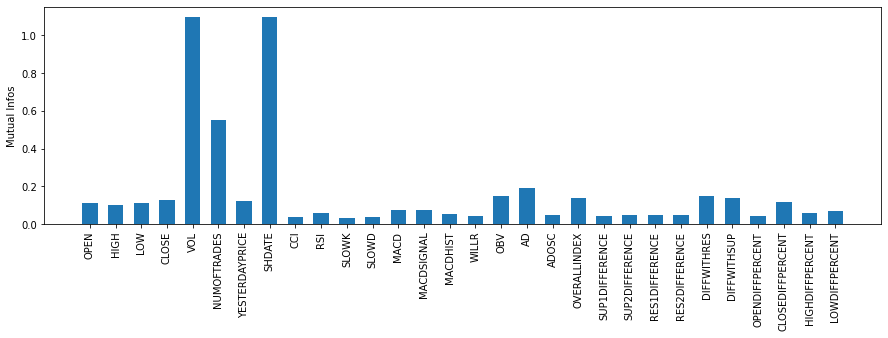

In [618]:
mutualInfos = featureSelectionWithMutualInfo(features, labels)
x = [i for i in range(len(mutualInfos))]
plt.figure(figsize = (15, 4))
plt.bar(x, mutualInfos, width = 0.6)
plt.xticks(x, features.columns, rotation = 90)
plt.ylabel("Mutual Infos")
plt.show()

In [150]:
def splitTrainTest(features, labels):
    years = np.floor(features["SHDATE"] / 10000) 
    trainFeatures = features.loc[(years % 2 == 0), :]
    testFeatures = features.loc[years % 2 == 1, :]
    trainLabels = labels.loc[trainFeatures.index]
    testLabels = labels.loc[testFeatures.index]
    print(trainFeatures)
    print(testFeatures)
    print(trainLabels)
    print(testLabels)
    return trainFeatures, testFeatures, trainLabels, testLabels

In [40]:
def splitTrainTest2(features, labels):
    years = np.floor(features["SHDATE"] / 10000) 
    trainFeatures = features.loc[years < 1397, :]
    testFeatures = features.loc[years >= 1397, :]
    trainLabels = labels.loc[trainFeatures.index]
    testLabels = labels.loc[testFeatures.index]
    print(trainFeatures)
    print(testFeatures)
    print(trainLabels)
    print(testLabels)
    return trainFeatures, testFeatures, trainLabels, testLabels

In [619]:
trainFeatures, testFeatures, trainLabels, testLabels = splitTrainTest(features, labels)

         OPEN  HIGH   LOW  ...  CLOSEDIFFPERCENT  HIGHDIFFPERCENT  LOWDIFFPERCENT
324     35.90    36    36  ...          0.946101         0.000000        2.857143
325     36.26    36    36  ...          2.982107         0.000000        0.000000
326     37.34    37    37  ...          2.978489         2.777778        2.777778
327     38.46    38    38  ...          2.999464         2.702703        2.702703
328     39.08    40    38  ...          2.730109         5.263158        0.000000
...       ...   ...   ...  ...               ...              ...             ...
2825  3320.00  3370  3270  ...         -1.201201        -0.295858       -1.801802
2826  3250.00  3280  3230  ...         -1.823708        -2.670623       -1.223242
2827  3190.00  3230  3170  ...         -1.238390        -1.524390       -1.857585
2828  3130.00  3190  3130  ...         -1.880878        -1.238390       -1.261830
2829  3070.00  3100  3070  ...         -1.597444        -2.821317       -1.916933

[1260 rows x 30

In [620]:
trainFeatures = trainFeatures.drop(columns = ["SHDATE"])
testFeatures = testFeatures.drop(columns = ["SHDATE"])
print(trainFeatures)
print(testFeatures)

         OPEN  HIGH   LOW  ...  CLOSEDIFFPERCENT  HIGHDIFFPERCENT  LOWDIFFPERCENT
324     35.90    36    36  ...          0.946101         0.000000        2.857143
325     36.26    36    36  ...          2.982107         0.000000        0.000000
326     37.34    37    37  ...          2.978489         2.777778        2.777778
327     38.46    38    38  ...          2.999464         2.702703        2.702703
328     39.08    40    38  ...          2.730109         5.263158        0.000000
...       ...   ...   ...  ...               ...              ...             ...
2825  3320.00  3370  3270  ...         -1.201201        -0.295858       -1.801802
2826  3250.00  3280  3230  ...         -1.823708        -2.670623       -1.223242
2827  3190.00  3230  3170  ...         -1.238390        -1.524390       -1.857585
2828  3130.00  3190  3130  ...         -1.880878        -1.238390       -1.261830
2829  3070.00  3100  3070  ...         -1.597444        -2.821317       -1.916933

[1260 rows x 29

In [ ]:
# Don't run!
# Drop features with very low mutual infos
trainFeatures = trainFeatures.drop(columns = ["CCI"])
testFeatures = testFeatures.drop(columns = ["CCI"])
featureList.remove("CCI")
trainFeatures = trainFeatures.drop(columns = ["SLOWK"])
testFeatures = testFeatures.drop(columns = ["SLOWK"])
featureList.remove("SLOWK")
trainFeatures = trainFeatures.drop(columns = ["SLOWD"])
testFeatures = testFeatures.drop(columns = ["SLOWD"])
featureList.remove("SLOWD")
trainFeatures = trainFeatures.drop(columns = ["MACDHIST"])
testFeatures = testFeatures.drop(columns = ["MACDHIST"])
featureList.remove("MACDHIST")

In [ ]:
# Don't run!
# Drop features with very high mutual infos
trainFeatures = trainFeatures.drop(columns = ["VOL"])
testFeatures = testFeatures.drop(columns = ["VOL"])
featureList.remove("VOL")

In [621]:
# Drop price absolute values
trainFeatures = trainFeatures.drop(columns = ["OPEN"])
testFeatures = testFeatures.drop(columns = ["OPEN"])
featureList.remove("OPEN")
trainFeatures = trainFeatures.drop(columns = ["CLOSE"])
testFeatures = testFeatures.drop(columns = ["CLOSE"])
featureList.remove("CLOSE")
trainFeatures = trainFeatures.drop(columns = ["HIGH"])
testFeatures = testFeatures.drop(columns = ["HIGH"])
featureList.remove("HIGH")
trainFeatures = trainFeatures.drop(columns = ["LOW"])
testFeatures = testFeatures.drop(columns = ["LOW"])
featureList.remove("LOW")
trainFeatures = trainFeatures.drop(columns = ["YESTERDAYPRICE"])
testFeatures = testFeatures.drop(columns = ["YESTERDAYPRICE"])
featureList.remove("YESTERDAYPRICE")

In [44]:
def baggingDecisionTree(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees, maxSamples, maxFeatures):
    model = DecisionTreeClassifier(criterion = "entropy", max_depth = maxDepth)
    bagging = BaggingClassifier(model, n_estimators = numOfTrees, max_samples = maxSamples, 
                                max_features = maxFeatures, random_state = 1)
    bagging.fit(trainFeatures, trainLabels)
    trainPredictedLabels = bagging.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = bagging.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep, bagging.estimators_

In [45]:
maxDepth = 8
numOfTrees = 115
maxSamples = 0.2
maxFeatures = 1.0

trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep, baggingTrees =\
 baggingDecisionTree(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees, maxSamples, maxFeatures)
print("Bagging Decision Tree")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Bagging Decision Tree
---------------------------------
Train: 
Accuracy:  0.7396825396825397
Precision:  0.7442914765758829
Recall:  0.7396825396825397
Test: 
Accuracy:  0.5552977571539056
Precision:  0.5468150888106506
Recall:  0.5552977571539056

              precision    recall  f1-score   support

        -1.0       0.51      0.39      0.44       407
         0.0       0.62      0.75      0.68       485
         1.0       0.50      0.49      0.49       401

    accuracy                           0.56      1293
   macro avg       0.54      0.54      0.54      1293
weighted avg       0.55      0.56      0.55      1293



In [ ]:
def visualizeTree(tree):
    fittedModel = tree.fit(trainFeatures, trainLabels)
    fig = plt.figure(figsize=(220, 220))
    plot_tree(tree, feature_names = list(trainFeatures), filled = True)
    plt.close(fig)
    fig.savefig("decistion_tree.png")

In [ ]:
visualizeTree(baggingTrees[0])

In [ ]:
def visualizeTree2(tree):
#     fittedModel = tree.fit(trainFeatures, trainLabels)
    text_representation = export_text(tree, feature_names = list(trainFeatures))
    print(text_representation)

In [ ]:
visualizeTree2(baggingTrees[1])

|--- VOL <= 11692886.50
|   |--- ADOSC <= 5582609.00
|   |   |--- CLOSEDIFFPERCENT <= 3.90
|   |   |   |--- SLOWD <= 74.40
|   |   |   |   |--- OBV <= 809546048.00
|   |   |   |   |   |--- CCI <= 38.98
|   |   |   |   |   |   |--- SLOWD <= 49.58
|   |   |   |   |   |   |   |--- LOWDIFFPERCENT <= -2.25
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- LOWDIFFPERCENT >  -2.25
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- SLOWD >  49.58
|   |   |   |   |   |   |   |--- MACDHIST <= -0.30
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- MACDHIST >  -0.30
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- CCI >  38.98
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- OBV >  809546048.00
|   |   |   |   |   |--- CCI <= 145.10
|   |   |   |   |   |   |--- SLOWK <= 22.80
|   |   |   |   |   |   |   |--- NUMOFTRADES <= 216.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |

In [46]:
def randomForest(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees, maxSamples, maxFeatures):
    model = RandomForestClassifier(max_depth = maxDepth, n_estimators = numOfTrees, max_samples = maxSamples,
                                   max_features = maxFeatures, random_state = None)
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep, model.estimators_, predictedLabels

In [47]:
maxDepth = 8
numOfTrees = 120
maxSamples = 0.2
maxFeatures = "auto"

trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep, forestTrees, testPredictedLabels =\
 randomForest(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees, maxSamples, maxFeatures)
print("Random Forest")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Random Forest
---------------------------------
Train: 
Accuracy:  0.7285714285714285
Precision:  0.7386694194020293
Recall:  0.7285714285714285
Test: 
Accuracy:  0.5668986852281516
Precision:  0.5602298295266669
Recall:  0.5668986852281516

              precision    recall  f1-score   support

        -1.0       0.51      0.41      0.46       407
         0.0       0.64      0.73      0.68       485
         1.0       0.51      0.53      0.52       401

    accuracy                           0.57      1293
   macro avg       0.55      0.56      0.55      1293
weighted avg       0.56      0.57      0.56      1293



In [ ]:
visualizeTree2(forestTrees[1])

|--- NUMOFTRADES <= 306.50
|   |--- LOWDIFFPERCENT <= -1.99
|   |   |--- SUP2DIFFERENCE <= 26.97
|   |   |   |--- class: 2.0
|   |   |--- SUP2DIFFERENCE >  26.97
|   |   |   |--- MACDSIGNAL <= 1.95
|   |   |   |   |--- AD <= 677291136.00
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- AD >  677291136.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- MACDSIGNAL >  1.95
|   |   |   |   |--- NUMOFTRADES <= 32.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- NUMOFTRADES >  32.50
|   |   |   |   |   |--- class: 0.0
|   |--- LOWDIFFPERCENT >  -1.99
|   |   |--- AD <= 274785104.00
|   |   |   |--- ADOSC <= 155272.75
|   |   |   |   |--- MACDHIST <= 0.08
|   |   |   |   |   |--- LOWDIFFPERCENT <= 0.26
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- LOWDIFFPERCENT >  0.26
|   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- MACDHIST >  0.08
|   |   |   |   |   |--- OBV <= 1010451392.00
|   |   |   |   |   |   |--- SUP1DIFFERENCE <= 7.97
|   |  

In [ ]:
def writeOutputFile(filename, testFeatures, testLabels, testPredictedLabels):
    testFeatures.reset_index(drop = True, inplace = True)
    testLabels = pd.DataFrame(testLabels)
    testLabels.reset_index(drop = True, inplace = True)
    testPredictedLabels = pd.DataFrame(testPredictedLabels, columns = ['PREDICTEDPRICEDIRECTION'])
    pd.concat([testFeatures, testLabels, testPredictedLabels], axis = 1).to_csv(filename)

In [ ]:
writeOutputFile("output.csv", testFeatures, testLabels, testPredictedLabels)

In [48]:
def gradientBoosting(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees, 
                     subSample, maxFeatures, lossFunc, learningRate):
    model = GradientBoostingClassifier(max_depth = maxDepth, n_estimators = numOfTrees, subsample = subSample,
                                   max_features = maxFeatures, random_state = None, 
                                   loss = lossFunc, learning_rate = learningRate)
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [49]:
maxDepth = 5
numOfTrees = 10
subSample = 0.2
maxFeatures = 10
lossFunc = "deviance"
lrList = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

print("Gradient Boosting")
print("---------------------------------")

for learningRate in lrList:
    trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
     gradientBoosting(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees, 
                     subSample, maxFeatures, lossFunc, learningRate)
    
    print("Learning rate: ", learningRate)
    print("Train: ")
    print("Accuracy: ", trainAccuracy)
    print("Precision: ", trainPrecision)
    print("Recall: ", trainRecall)
    print("Test: ")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print()
    print(rep)
    print("----------------------------------------------------------------")

Gradient Boosting
---------------------------------
Learning rate:  0.05
Train: 
Accuracy:  0.6238095238095238
Precision:  0.6432176240012061
Recall:  0.6238095238095238
Test: 
Accuracy:  0.5251353441608662
Precision:  0.5256075289886474
Recall:  0.5251353441608662

              precision    recall  f1-score   support

        -1.0       0.49      0.19      0.28       407
         0.0       0.62      0.67      0.64       485
         1.0       0.46      0.69      0.55       401

    accuracy                           0.53      1293
   macro avg       0.52      0.52      0.49      1293
weighted avg       0.53      0.53      0.50      1293

----------------------------------------------------------------
Learning rate:  0.075
Train: 
Accuracy:  0.6404761904761904
Precision:  0.6477821682768203
Recall:  0.6404761904761904
Test: 
Accuracy:  0.5011600928074246
Precision:  0.49424673171073275
Recall:  0.5011600928074246

              precision    recall  f1-score   support

        -1.0   

In [51]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from random import shuffle

import time
from datetime import timedelta
from datetime import datetime

In [622]:
labelIndex = len(featureList)

In [623]:
def preprocessTorch(data):
    stdScaler = StandardScaler()
    flDf = pd.concat([data[featureList].astype(np.float32),
                      data["PRICEDIRECTION"].astype(np.long)], axis=1)
    stdData = stdScaler.fit_transform(flDf)
    for i in range(len(stdData)):
        if stdData[i][labelIndex] < -0.5:
            stdData[i][labelIndex] = 0
        elif stdData[i][labelIndex] < 0.5:
            stdData[i][labelIndex] = 1
        else:
            stdData[i][labelIndex] = 2
    print(type(stdData))
    return stdData

In [624]:
class StockDataset(Dataset):
    """Stock dataset."""

    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): DataFrame containing Stock data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = preprocessTorch(data).astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        label = 0
        if self.data[idx][labelIndex] < 0.5:
            label = torch.tensor(0, dtype=torch.long)
        elif self.data[idx][labelIndex] < 1.5:
            label = torch.tensor(1, dtype=torch.long)
        else:
            label = torch.tensor(2, dtype=torch.long)

        sample = {"Indicator": self.data[idx][0:labelIndex],
                  "Direction": label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
dataset = StockDataset(data)
classes = [0, 1, 2]
classSpec = [[] for i in range(3)]
for i in range(len(dataset)):
    classSpec[int(labels[i:i+1].item()) + 1].append(i)

In [626]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.relu):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * labelIndex, 1 * 30 * 35)
        self.act1 = act

        self.layer2 = nn.Linear(1 * 30 * 35, 1 * 20 * 15)
        self.act2 = act

        self.layer3 = nn.Linear(1 * 20 * 15, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        return x

In [627]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [628]:
model = Model(len(classes))
model = model.to(device)

In [629]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [630]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

    total_time = 0.
    avgLossSeq = []

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()
        for (idx, batch) in enumerate(train_loader):
            
            samples = batch["Indicator"]
            labels = batch["Direction"]
            
            samples = samples.to(device)
            labels = labels.to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(samples)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        avgLossSeq.append(average_loss)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
    print('total training time: %.3f minutes' % (total_time / 60))
    return avgLossSeq 

In [631]:
def calc_model_accuracy(model, data_loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
        for (idx, batch) in enumerate(data_loader):
            samples = batch["Indicator"]
            labels = batch["Direction"]
            outputs = model(samples.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.to('cpu') == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))

    
def calc_model_precisions(model, data_loader, numOfClasses=3):
    precisionPerLabel = [[0, 0] for i in range(3)]
    with torch.no_grad():
        for (idx, batch) in enumerate(data_loader):
            samples = batch["Indicator"]
            labels = batch["Direction"]
            outputs = model(samples.to(device))
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(predicted)):
                precisionPerLabel[labels[i]][0] += int(predicted[i] == labels[i])
                precisionPerLabel[predicted[i]][1] += 1
    result = []
    for x in precisionPerLabel:
        if x[1] == 0:
            result += [0]
        else:
            result += [x[0]/x[1] * 100]
        # print("COUNT OF GROUP IS: ", x[1])
    return result
    
    
def calc_model_recalls(model, data_loader, numOfClasses=3):
    recallPerLabel = [[0, 0] for i in range(3)]
    with torch.no_grad():
        for (idx, batch) in enumerate(data_loader):
            samples = batch["Indicator"]
            labels = batch["Direction"]
            outputs = model(samples.to(device))
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(predicted)):
                recallPerLabel[labels[i]][0] += int(predicted[i] == labels[i])
                recallPerLabel[labels[i]][1] += 1
    result = []
    for x in recallPerLabel:
        if x[1] == 0:
            result += [0]
        else:
            result += [x[0]/x[1] * 100]
        # print("COUNT OF GROUP IS: ", x[1])
    return result

In [632]:
def printResult(model, train_loader, test_loader, avgLossSeq):
    print('\n--- Train Data')
    calc_model_accuracy(model, train_loader)
    print('--- Test Data')
    calc_model_accuracy(model, test_loader)
    print('\n')
    
    X = np.arange(3)
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X - 0.125, calc_model_precisions(model, train_loader), color = 'b', width = 0.25)
    ax.bar(X + 0.125, calc_model_precisions(model, test_loader), color = 'r', width = 0.25)
    plt.xticks([i for i in range(3)], rotation='vertical')
    ax.legend(labels=['Train', 'Test'])
    plt.title('Model Precision on Train and Test Data per Class')
    plt.xlabel('Label (-1, 0, 1)')
    plt.ylabel('Precision')
    plt.show()
    print()
    
    X = np.arange(3)
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X - 0.125, calc_model_recalls(model, train_loader), color = 'b', width = 0.25)
    ax.bar(X + 0.125, calc_model_recalls(model, test_loader), color = 'r', width = 0.25)
    plt.xticks([i for i in range(3)], rotation='vertical')
    ax.legend(labels=['Train', 'Test'])
    plt.title('Model Recall on Train and Test Data per Class')
    plt.xlabel('Label (-1, 0, 1)')
    plt.ylabel('Recall')
    plt.show()
    print()

    fig = plt.figure(figsize=(6,3))
    ax = fig.add_axes([0,0,1,1])
    Y = []
    for i in avgLossSeq:
        if np.isnan(i):
            Y.append(-1)
        else:
            Y.append(i)
    ax.plot([i+1 for i in range(len(Y))], Y)
    ax.set_ylim([min(Y)-1, max(Y)+1])
    plt.title('Average Train Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Train Loss')
    plt.show()

In [633]:
def trainModel(initWsTo0=False, learning_rate=0.01, batchSize=64, momentum=0.5, 
               epoch=10, act=F.relu, weight_decay=0, onGPU=True):

    validation_split = 0.2

    train_indices = []
    test_indices = []
    for i in range(len(classSpec)):
        trainTemp, testTemp = train_test_split(classSpec[i], test_size=0.2)
        train_indices += trainTemp
        test_indices += testTemp

    shuffle(train_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataset = StockDataset(data)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, sampler=train_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, sampler=test_sampler, num_workers=2)

    global device
    model = Model(3, act=act)
    if initWsTo0:
        def init_weights(m):
            if type(m) == nn.Linear:
                m.weight.data.fill_(0.00)
                m.bias.data.fill_(0.00)
        model.apply(init_weights)

    if onGPU:
        model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    avgLossSeq = fit(model, train_loader, device, criterion, optimizer, num_epochs=epoch)
    printResult(model, train_loader, test_loader, avgLossSeq)

<class 'numpy.ndarray'>
epoch 1, train_loss: 1.069, time elapsed: 0.472964 seconds
epoch 2, train_loss: 1.032, time elapsed: 0.436395 seconds
epoch 3, train_loss: 1.011, time elapsed: 0.463635 seconds
epoch 4, train_loss: 0.996, time elapsed: 0.466175 seconds
epoch 5, train_loss: 0.984, time elapsed: 0.459263 seconds
epoch 6, train_loss: 0.974, time elapsed: 0.453038 seconds
epoch 7, train_loss: 0.966, time elapsed: 0.448884 seconds
epoch 8, train_loss: 0.959, time elapsed: 0.471407 seconds
epoch 9, train_loss: 0.953, time elapsed: 0.456068 seconds
epoch 10, train_loss: 0.947, time elapsed: 0.47298 seconds
epoch 11, train_loss: 0.943, time elapsed: 0.482419 seconds
epoch 12, train_loss: 0.937, time elapsed: 0.464005 seconds
epoch 13, train_loss: 0.934, time elapsed: 0.488849 seconds
epoch 14, train_loss: 0.931, time elapsed: 0.47051 seconds
epoch 15, train_loss: 0.926, time elapsed: 0.472643 seconds
epoch 16, train_loss: 0.923, time elapsed: 0.484584 seconds
epoch 17, train_loss: 0.919

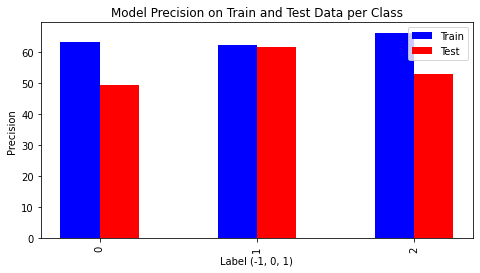

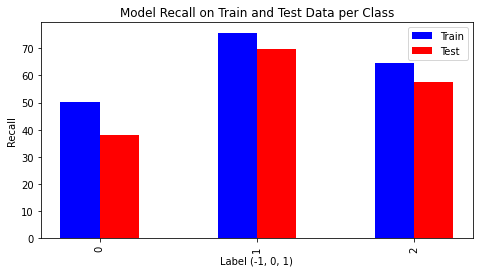

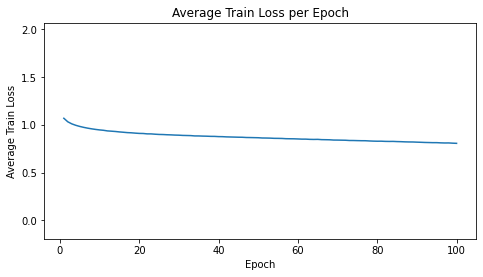

In [637]:
trainModel(epoch=100, learning_rate=0.007, batchSize=64, onGPU=False)